# Hypothesis Testing for group mean difference

In [2]:
# import libraries
import scipy.stats

import matplotlib.pyplot as plt

import seaborn as sns

import numpy as np
import pandas as pd

from ipywidgets import interact, interactive, fixed
import ipywidgets as widgets

In [5]:
# load data  ##### make changes here
# df = pd.read_csv('data/us_job_market_discrimination.dta')
df = pd.io.stata.read_stata('data/us_job_market_discrimination.dta')

In [6]:
df.head(5)

,id,ad,education,ofjobs,yearsexp,honors,volunteer,military,empholes,occupspecific,...,compreq,orgreq,manuf,transcom,bankreal,trade,busservice,othservice,missind,ownership
0,b,1,4,2,6,0,0,0,1,17,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,
1,b,1,3,3,6,0,1,1,0,316,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,
2,b,1,4,1,6,0,0,0,0,19,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,
3,b,1,3,4,6,0,1,0,1,313,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,
4,b,1,3,3,22,0,0,0,0,313,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,Nonprofit


In [7]:
group1name=df[df.race=='w'].call  ### make change here

In [8]:
group2name=df[df.race=='b'].call   ### make change here

In [9]:
# text on the plot 
def text(x, y, s):
    """Plot a string at a given location in axis coordinates.
    
    x: coordinate
    y: coordinate
    s: string
    """
    ax = plt.gca()
    plt.text(x, y, s,
                horizontalalignment='left',
                verticalalignment='top',
                transform=ax.transAxes)

# 1. Hypothesis Test 

In [10]:
# structure of hypothesis test 
class HypothesisTest(object):
    """Represents a hypothesis test."""

    def __init__(self, data):
        """Initializes.

        data: data in whatever form is relevant
        """
        self.data = data
        self.MakeModel()
        self.actual = self.TestStatistic(data)
        self.test_stats = None

    def PValue(self, iters=1000):
        """Computes the distribution of the test statistic and p-value.

        iters: number of iterations

        returns: float p-value
        """
        self.test_stats = np.array([self.TestStatistic(self.RunModel()) 
                                       for _ in range(iters)])

        count = sum(self.test_stats >= self.actual)
        return count / iters

    def MaxTestStat(self):
        """Returns the largest test statistic seen during simulations.
        """
        return max(self.test_stats)

    def PlotHist(self, label=None):
        """Draws a Cdf with vertical lines at the observed test stat.
        """
        ys, xs, patches = plt.hist(ht.test_stats, color = 'grey' )
        plt.vlines(self.actual, 0, max(ys), linewidth=3, color='red')
        plt.xlabel('test statistic')
        plt.ylabel('count')

    def TestStatistic(self, data):
        """Computes the test statistic.

        data: data in whatever form is relevant        
        """
        raise UnimplementedMethodException()

    def MakeModel(self):
        """Build a model of the null hypothesis.
        """
        pass

    def RunModel(self):
        """Run the model of the null hypothesis.

        returns: simulated data
        """
        raise UnimplementedMethodException()


In [11]:
class DiffMeansPermute(HypothesisTest):
    """Tests a difference in means by permutation."""

    def TestStatistic(self, data):
        """Computes the test statistic.

        data: data in whatever form is relevant        
        """
        group1, group2 = data
        test_stat = abs(group1.mean() - group2.mean())
        return test_stat

    def MakeModel(self):
        """Build a model of the null hypothesis.
        """
        group1, group2 = self.data
        self.n, self.m = len(group1), len(group2)
        self.pool = np.hstack((group1, group2))

    def RunModel(self):
        """Run the model of the null hypothesis.

        returns: simulated data
        """
        np.random.shuffle(self.pool)
        data = self.pool[:self.n], self.pool[self.n:]
        return data

In [12]:
# call functions
data = (group1name, group2name)
ht = DiffMeansPermute(data)
p_value = ht.PValue(iters=1000)
print('\nmeans ......')
print('p-value =', p_value)
print('actual =', ht.actual)
print('ts max =', ht.MaxTestStat())


means ......
p-value = 0.0
actual = 0.03203285485506058
ts max = 0.022998


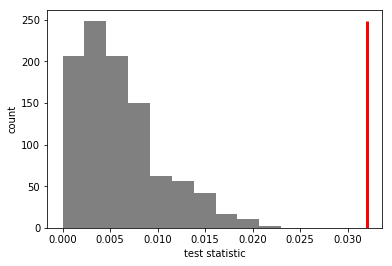

In [13]:
# show plot
ht.PlotHist()
plt.show()

# 2. Effect Size: Cohent_d

In [14]:
# resampler 
class Resampler(object):
    """Represents a framework for computing sampling distributions."""
    
    def __init__(self, sample, xlim=None):
        """Stores the actual sample."""
        self.sample = sample
        self.n = len(sample)
        self.xlim = xlim
        
    def resample(self):
        """Generates a new sample by choosing from the original
        sample with replacement.
        """
        new_sample = np.random.choice(self.sample, self.n, replace=True)
        return new_sample
    
    def sample_stat(self, sample):
        """Computes a sample statistic using the original sample or a
        simulated sample.
        """
        return sample.mean()
    
    def compute_sampling_distribution(self, iters=1000):
        """Simulates many experiments and collects the resulting sample
        statistics.
        """
        stats = [self.sample_stat(self.resample()) for i in range(iters)]
        return np.array(stats)
    
    def plot_sampling_distribution(self):
        """Plots the sampling distribution."""
        sample_stats = self.compute_sampling_distribution()
        se = sample_stats.std()
        ci = np.percentile(sample_stats, [5, 95])
    
        plt.hist(sample_stats)
        plt.xlabel('sample statistic')
        plt.xlim(self.xlim)
        text(0.03, 0.95, 'CI [%0.2f %0.2f]' % tuple(ci))
        text(0.03, 0.85, 'SE %0.2f' % se)
        plt.show()


In [15]:
# Cohen Effect d on group mean
def CohenEffectSize(group1, group2):
    """Compute Cohen's d.

    group1: Series or NumPy array
    group2: Series or NumPy array

    returns: float
    """
    diff = group1.mean() - group2.mean()

    n1, n2 = len(group1), len(group2)
    var1 = group1.var()
    var2 = group2.var()

    pooled_var = (n1 * var1 + n2 * var2) / (n1 + n2)
    d = diff / np.sqrt(pooled_var)
    return d

class CohenResampler(Resampler):
    def __init__(self, group1, group2, xlim=None):
        self.group1 = group1
        self.group2 = group2
        self.xlim = xlim
    def resample(self):
        n, m = len(self.group1), len(self.group2)
        group1 = np.random.choice(self.group1, n, replace=True)
        group2 = np.random.choice(self.group2, m, replace=True)
        return group1, group2
    def sample_stat(self, groups):
        group1, group2 = groups
        return group1.mean()-group2.mean()

In [16]:
# plot overlap & superiority 
def eval_pdf(rv, num=4):
    mean, std = rv.mean(), rv.std()
    xs = np.linspace(mean - num*std, mean + num*std, 100)
    ys = rv.pdf(xs)
    return xs, ys

def overlap_superiority(control, treatment, n=1000):
    """Estimates overlap and superiority based on a sample.
    
    control: scipy.stats rv object
    treatment: scipy.stats rv object
    n: sample size
    """
    control_sample = control.rvs(n)
    treatment_sample = treatment.rvs(n)
    thresh = (control.mean() + treatment.mean()) / 2
    
    control_above = sum(control_sample > thresh)
    treatment_below = sum(treatment_sample < thresh)
    overlap = (control_above + treatment_below) / n
    
    superiority = (treatment_sample > control_sample).mean()
    return overlap, superiority

def plot_pdfs(cohen_d=2):
    """Plot PDFs for distributions that differ by some number of stds.
    
    cohen_d: number of standard deviations between the means
    """
    control = scipy.stats.norm(0, 1)
    treatment = scipy.stats.norm(cohen_d, 1)
    xs, ys = eval_pdf(control)
    plt.fill_between(xs, ys, label='control', color='green', alpha=0.7)

    xs, ys = eval_pdf(treatment)
    plt.fill_between(xs, ys, label='treatment', color='yellow', alpha=0.7)
    
    o, s = overlap_superiority(control, treatment)
    plt.text(0, 0.05, 'overlap ' + str(o))
    plt.text(0, 0.15, 'superiority ' + str(s))
    plt.show()
    #print('overlap', o)
    #print('superiority', s)

In [ ]:
def interact_func(n, xlim):
    sample = pop_temp.rvs(n)
    resampler = Resampler(sample, xlim=xlim)
    resampler.plot_sampling_distribution()

# 1) plot distribution and CI for mean difference

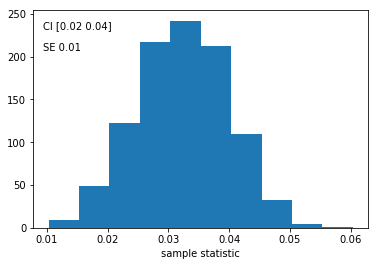

In [17]:
# plot the histogram of mean difference and 90% confidence interval
resampler = CohenResampler(group1name, group2name)
resampler.plot_sampling_distribution()

# 2) plot cohen_d with overlap & superiority rate

In [19]:
Cohen_d = CohenEffectSize(group1name, group2name)

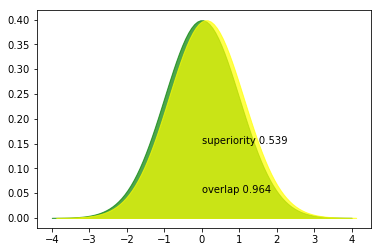

In [20]:
# plot of Cohen_d 
plot_pdfs(Cohen_d)

In [21]:
# interactive plot Cohen_d
slider = widgets.FloatSlider(min=0, max=1, value=2)
interact(plot_pdfs, cohen_d=slider)
None